# Classifying Fashion-MNIST

MNIST is actually quite trivial with neural networks where you can easily achieve better than 97% accuracy. Fashion-MNIST is a set of 28x28 greyscale images of clothes. It's more complex than MNIST, so it's a better representation of the actual performance of your network, and a better representation of datasets you'll use in the real world.

In [1]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

# Building the Network

In [2]:
from torch import nn
import torch.nn.functional as F

In [3]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784,256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,64)
        self.fc4 = nn.Linear(64,10)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

# Train the Model

In [4]:
from torch import optim

In [5]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [6]:
train_losses, test_losses = [], []
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images = images.view(images.shape[0],-1)
        optimizer.zero_grad()
        log_ps = model.forward(images)
        
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else: #after passing each epoch on training set to check the model on test set
        test_loss=0
        accuracy = 0
        with torch.no_grad():
            for images, labels in testloader:
                images = images.view(images.shape[0], -1)
                
                logps = model.forward(images)
                test_loss += criterion(logps, labels)
                
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epochs: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epochs: 1/15..  Training Loss: 0.517..  Test Loss: 0.440..  Test Accuracy: 0.836
Epochs: 2/15..  Training Loss: 0.389..  Test Loss: 0.404..  Test Accuracy: 0.855
Epochs: 3/15..  Training Loss: 0.350..  Test Loss: 0.372..  Test Accuracy: 0.868
Epochs: 4/15..  Training Loss: 0.332..  Test Loss: 0.373..  Test Accuracy: 0.868
Epochs: 5/15..  Training Loss: 0.315..  Test Loss: 0.371..  Test Accuracy: 0.869
Epochs: 6/15..  Training Loss: 0.298..  Test Loss: 0.378..  Test Accuracy: 0.873
Epochs: 7/15..  Training Loss: 0.289..  Test Loss: 0.379..  Test Accuracy: 0.868
Epochs: 8/15..  Training Loss: 0.279..  Test Loss: 0.395..  Test Accuracy: 0.862
Epochs: 9/15..  Training Loss: 0.273..  Test Loss: 0.349..  Test Accuracy: 0.878
Epochs: 10/15..  Training Loss: 0.266..  Test Loss: 0.382..  Test Accuracy: 0.876
Epochs: 11/15..  Training Loss: 0.259..  Test Loss: 0.364..  Test Accuracy: 0.874
Epochs: 12/15..  Training Loss: 0.255..  Test Loss: 0.370..  Test Accuracy: 0.876
Epochs: 13/15..  Training

## Plotting the Loss

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

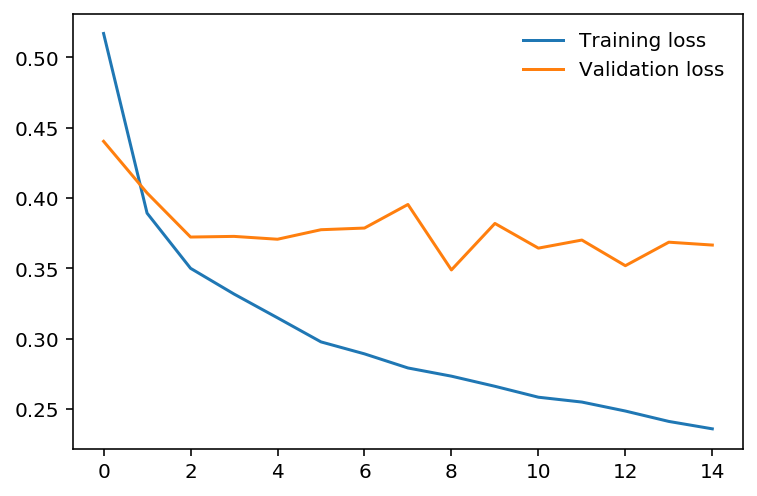

In [8]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

# Using the Architecture with Dropouts

In [9]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)
        return x

In [10]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [11]:
train_losses, test_losses = [], []
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        images = images.view(images.shape[0], -1)
        logps = model.forward(images)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    else:
        test_loss=0
        accuracy=0
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                images = images.view(images.shape[0], -1)
                
                logps = model.forward(images)
                test_loss += criterion(logps, labels)
                
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epochs: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}.. ".format(accuracy/len(testloader)))

Epochs: 1/15..  Training Loss: 0.607..  Test Loss: 0.494..  Test Accuracy: 0.819.. 
Epochs: 2/15..  Training Loss: 0.478..  Test Loss: 0.436..  Test Accuracy: 0.841.. 
Epochs: 3/15..  Training Loss: 0.451..  Test Loss: 0.417..  Test Accuracy: 0.852.. 
Epochs: 4/15..  Training Loss: 0.437..  Test Loss: 0.421..  Test Accuracy: 0.857.. 
Epochs: 5/15..  Training Loss: 0.426..  Test Loss: 0.407..  Test Accuracy: 0.856.. 
Epochs: 6/15..  Training Loss: 0.413..  Test Loss: 0.432..  Test Accuracy: 0.852.. 
Epochs: 7/15..  Training Loss: 0.410..  Test Loss: 0.407..  Test Accuracy: 0.855.. 
Epochs: 8/15..  Training Loss: 0.401..  Test Loss: 0.407..  Test Accuracy: 0.858.. 
Epochs: 9/15..  Training Loss: 0.394..  Test Loss: 0.403..  Test Accuracy: 0.861.. 
Epochs: 10/15..  Training Loss: 0.393..  Test Loss: 0.382..  Test Accuracy: 0.868.. 
Epochs: 11/15..  Training Loss: 0.383..  Test Loss: 0.389..  Test Accuracy: 0.864.. 
Epochs: 12/15..  Training Loss: 0.377..  Test Loss: 0.384..  Test Accuracy

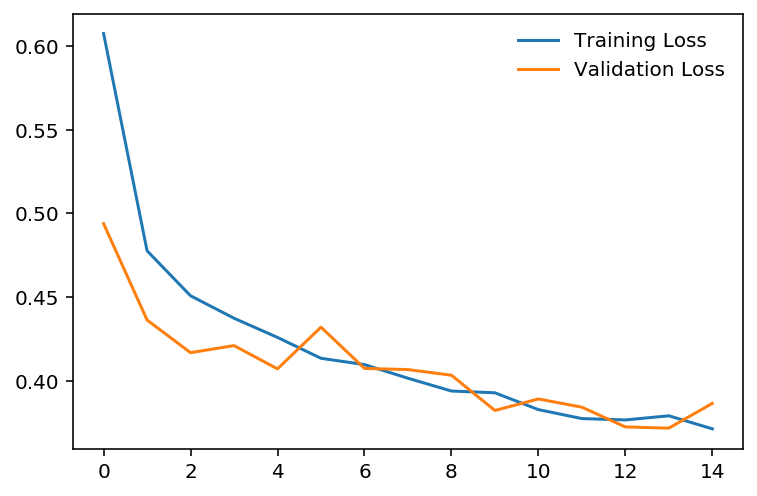

In [12]:
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.legend(frameon=False)

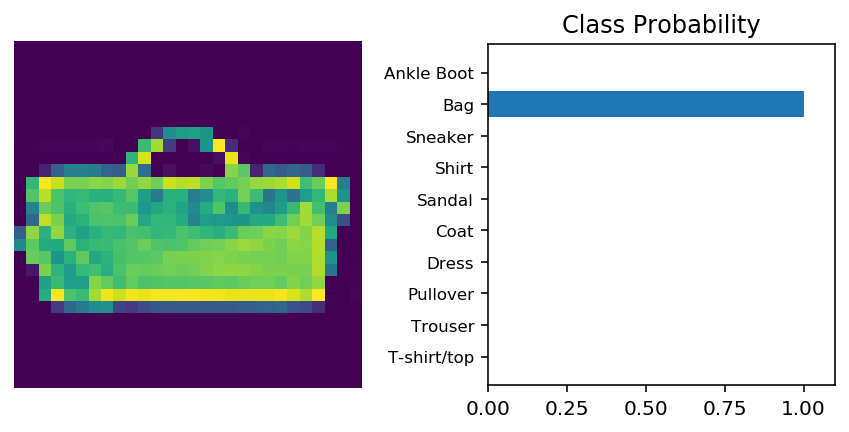

In [13]:
import temp

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
img = img.view(1, 784)

with torch.no_grad():
    output = model.forward(img)
    
ps = torch.exp(output)
temp.view_classify(img.view(1, 28, 28), ps, version='Fashion')